# OpenAP-TOP: 4D flight trajectory optimizer


## Install OpenAP


In [ ]:
%pip install openap
%pip install openap-top
%pip install cfgrib
%pip install ecmwflibs

In [8]:
import warnings
import matplotlib.pyplot as plt
from openap import top
import numpy as np
import pandas as pd
from openap import aero

import cartopy.feature as cf
import cartopy.crs as ccrs
from openap import aero

warnings.filterwarnings("ignore")

In [3]:
actype = "A320"
origin = "EHAM"
destination = "LGAV"

m0 = 0.85  # initial mass, faction of the maximum takeoff weight

## Define trip type

- `top.CompleteFlight()`: full trajectory, non-phase specific
- `top.Multiphase()`: full trajectory, including climbing, cruise, and descent
- `top.Climb()`
- `top.Cruise()`
- `top.Descent()`


In [3]:
optimizer = top.CompleteFlight(actype, origin, destination, m0)
flight = optimizer.trajectory(objective="fuel")

You can visualize the trajectory quickly with the `vis.trajectory()` function


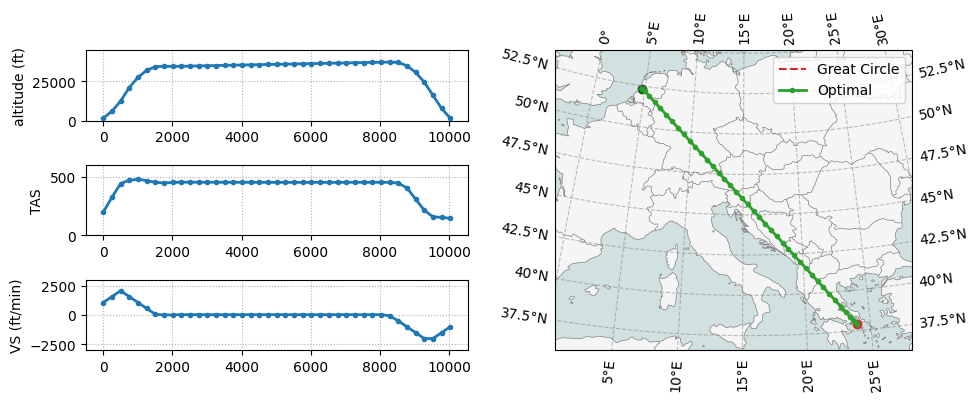

In [4]:
top.vis.trajectory(flight)
plt.show()

## Examples of different trajectories

### Multi-phase


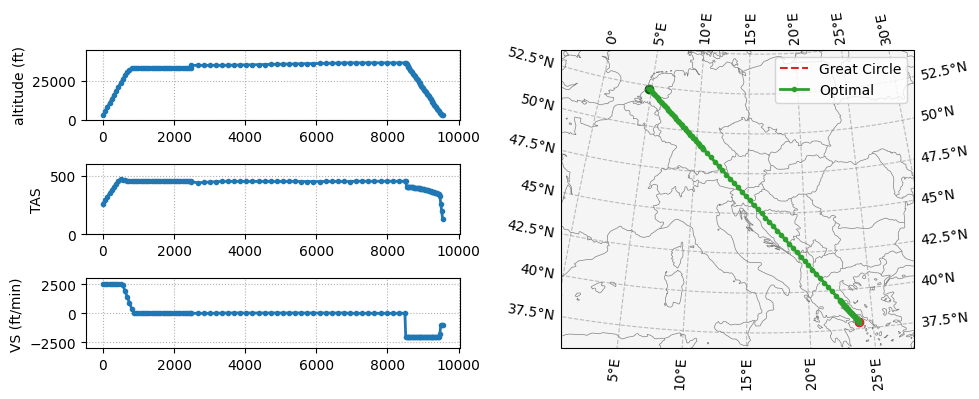

In [39]:
optimizer = top.MultiPhase(actype, origin, destination, m0)
flight = optimizer.trajectory(objective="fuel")

top.vis.trajectory(flight)
plt.show()

### Cruise phase only


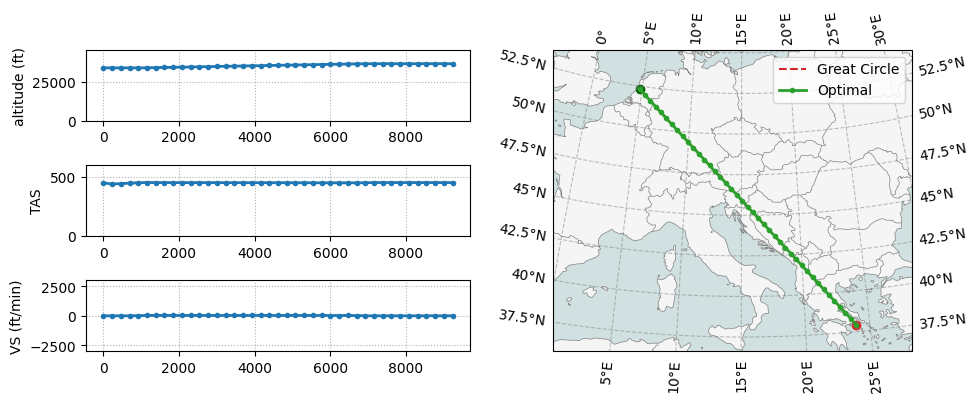

In [6]:
optimizer = top.Cruise(actype, origin, destination, m0)
flight = optimizer.trajectory(objective="fuel")

top.vis.trajectory(flight)
plt.show()

### Cruise phase only - with fixed altitude


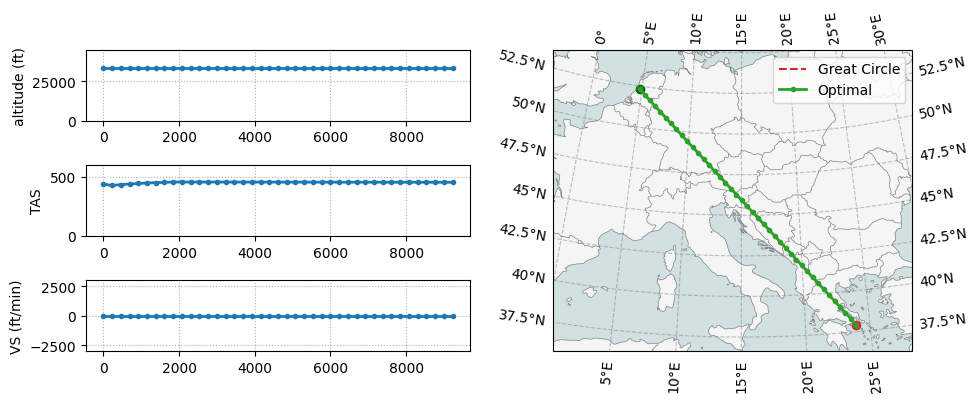

In [8]:
optimizer = top.Cruise(actype, origin, destination, m0)
optimizer.fix_cruise_altitude()
flight = optimizer.trajectory(objective="fuel")

top.vis.trajectory(flight)
plt.show()

## Using different built-in objective functions

In the following section, we text different objective functions, inlcuding:
- fuel consumption
- cost index, between 0 (fuel optimal) and 100 (time optimal)
- global warming potential, 100 years
- global temperature potential, 100 years


In [9]:
optimizer = top.CompleteFlight(actype, origin, destination, m0)

### Optimize for fuel consumption

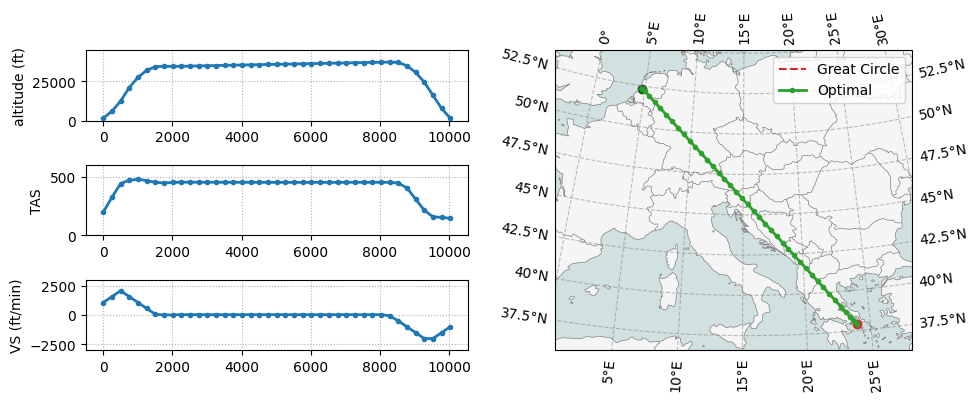

In [11]:
flight = optimizer.trajectory(objective="fuel")
top.vis.trajectory(flight)
plt.show()

### Optimize for a cost index

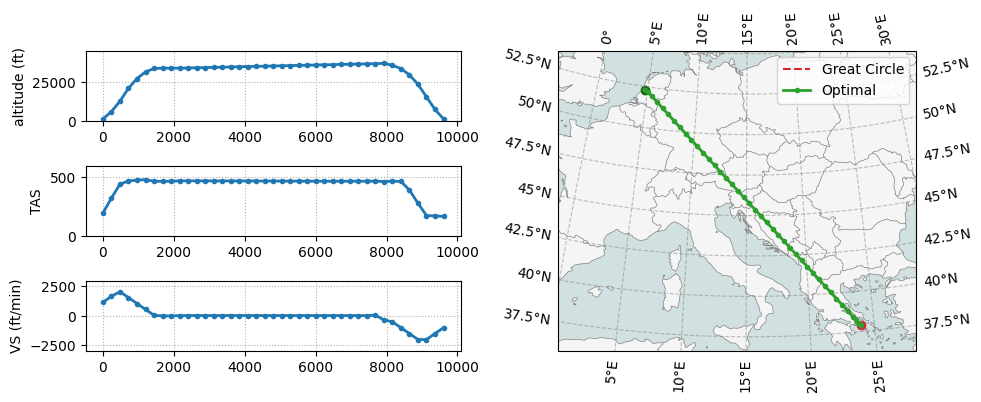

In [10]:
flight = optimizer.trajectory(objective="ci:60")
top.vis.trajectory(flight)
plt.show()

### Optimize for global warming potential

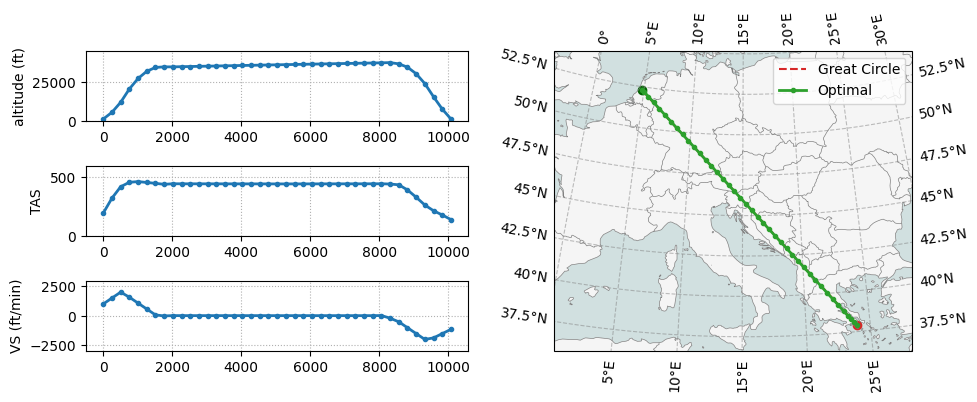

In [12]:
flight = optimizer.trajectory(objective="gwp100")
top.vis.trajectory(flight)
plt.show()

### Optimize for global temperature potential

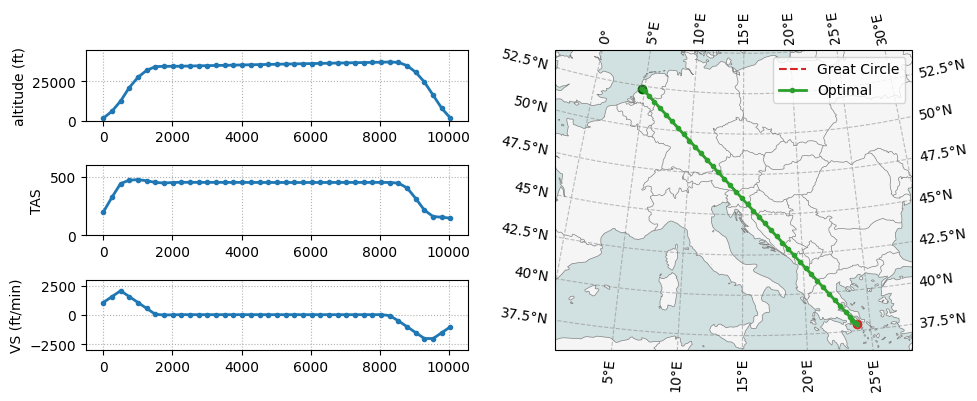

In [ ]:
flight = optimizer.trajectory(objective="gtp100")
top.vis.trajectory(flight)
plt.show()

### Specify different objective functions for different phases

You can specify different objective functions for different phases. For example, different cost index for climbing, cruising, and descending.

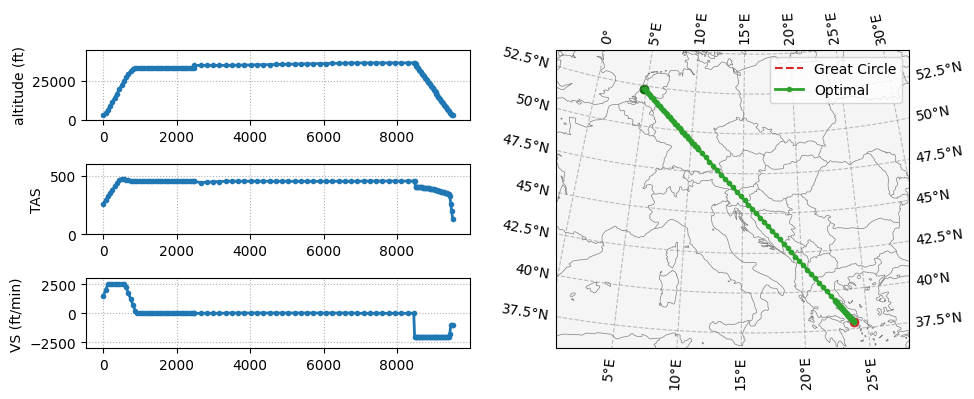

In [ ]:
optimizer = top.MultiPhase(actype, origin, destination, m0)
flight = optimizer.trajectory(objective=("ci:60", "ci:10", "ci:20"))  # Multiphase
top.vis.trajectory(flight)
plt.show()

# With wind

Wind data can be included in the optimization. The wind data can be in the form of a grib file.

Download example wind grib file at: https://surfdrive.surf.nl/files/index.php/s/iGaqQ7YS3FIJB7f/download

### Download the data

In [41]:
!mkdir -p data
!wget https://surfdrive.surf.nl/files/index.php/s/iGaqQ7YS3FIJB7f/download -O "data/era5_2021_05_01_0800.grib"


--2024-06-29 01:09:00--  https://surfdrive.surf.nl/files/index.php/s/iGaqQ7YS3FIJB7f/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.107.8.140, 145.107.56.140, 145.100.27.67, ...
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.107.8.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384171000 (366M) [application/octet-stream]
Saving to: ‘data/era5_2021-05-01_0800.grib’

data/era5_2021-05-0 100%[===================>] 366,37M  80,1MB/s    in 6,5s    

2024-06-29 01:09:07 (56,1 MB/s) - ‘data/era5_2021-05-01_0800.grib’ saved [384171000/384171000]



In [9]:
fgrib = "data/era5_2021_05_01_0800.grib"

windfield = top.tools.read_grib(fgrib)

optimizer = top.CompleteFlight("A320", "EHAM", "LEMD", m0=0.85)
optimizer.enable_wind(windfield)

flight = optimizer.trajectory(objective="fuel")

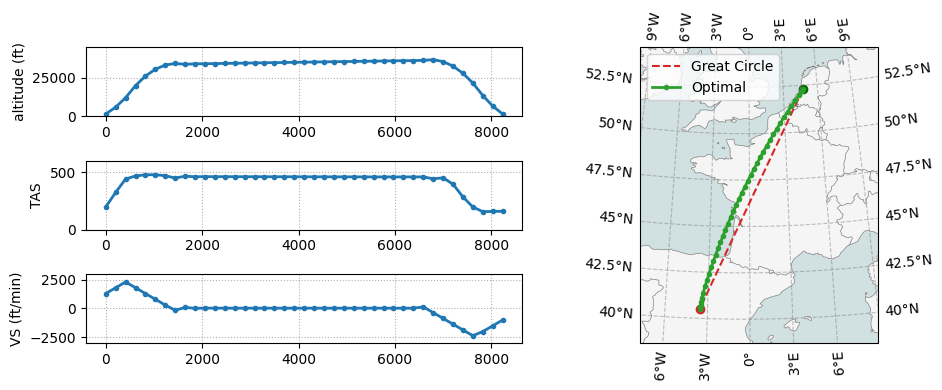

In [10]:
top.vis.trajectory(flight)
plt.show()

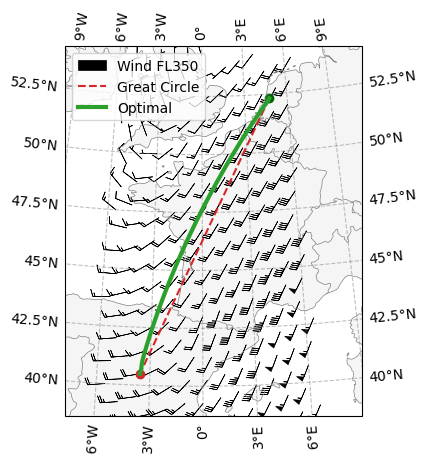

In [11]:


lat1, lon1 = flight.latitude.iloc[0], flight.longitude.iloc[0]
lat2, lon2 = flight.latitude.iloc[-1], flight.longitude.iloc[-1]

latmin, latmax = min(lat1, lat2), max(lat1, lat2)
lonmin, lonmax = min(lon1, lon2), max(lon1, lon2)

ax = plt.axes(
    projection=ccrs.TransverseMercator(
        central_longitude=flight.longitude.mean(), central_latitude=flight.latitude.mean()
    )
)

ax.set_extent([lonmin - 4, lonmax + 4, latmin - 2, latmax + 2])
ax.add_feature(cf.LAND, facecolor="#f5f5f5", lw=0)
ax.add_feature(cf.BORDERS, lw=0.5, color="gray")
ax.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
ax.coastlines(resolution="50m", lw=0.5, color="gray")

if windfield is not None:
    # get the closed altitude
    h_ = flight.altitude.median() * aero.ft
    fl = int(round(h_ / aero.ft / 100, -1))
    idx = np.argmin(abs(windfield.h.unique() - h_))
    windfield = (
        windfield.query(f"h=={windfield.h.unique()[idx]}")
        .query(f"longitude <= {lonmax + 2}")
        .query(f"longitude >= {lonmin - 2}")
        .query(f"latitude <= {latmax + 2}")
        .query(f"latitude >= {latmin - 2}")
    )

    ax.barbs(
        windfield.longitude.values[::15],
        windfield.latitude.values[::15],
        windfield.u.values[::15],
        windfield.v.values[::15],
        transform=ccrs.PlateCarree(),
        color="k",
        length=5,
        lw=0.5,
        label=f"Wind FL{fl}",
    )

# great circle
ax.scatter(lon1, lat1, c="darkgreen", transform=ccrs.Geodetic())
ax.scatter(lon2, lat2, c="tab:red", transform=ccrs.Geodetic())

ax.plot(
    [lon1, lon2],
    [lat1, lat2],
    label="Great Circle",
    color="tab:red",
    ls="--",
    transform=ccrs.Geodetic(),
)

# trajectory
ax.plot(
    flight.longitude,
    flight.latitude,
    color="tab:green",
    transform=ccrs.Geodetic(),
    linewidth=3,
    label="Optimal",
)

ax.legend()

plt.show()


# More complex optimization - 4D Cost functions


## Define objective function

Here I am using a 2D gaussian function to simulate a most complex cost gird. The 2D gaussian function is repeated for different flight levels, and shifted in time along the x-axis at different time. 


In [12]:
def gaussian(x, y):
    return -np.exp(-(x**2) - y**2)

# search ranges for the hump functions
x = np.linspace(-2, 2, 50)
y = np.linspace(-1, 1, 50)
z = np.linspace(0, 13_000, 10)
ts = np.arange(0, 4 * 3600, 3600)

X, Y, Z = np.meshgrid(x, y, z)

V = np.zeros((len(x), len(y), len(z), len(ts)))

# shift the minima with time
for i, ts_ in enumerate(ts):
    v = gaussian(X - i * 0.5, Y)
    V[:, :, :, i] = v

V = V - V.min()

# re-scale to our lon/lat grid
x_ = np.interp(x, (min(x), max(x)), (-10, 30))
y_ = np.interp(y, (min(y), max(y)), (35, 60))
X, Y, Z, TS = np.meshgrid(x_, y_, z, ts)


## Visualize the cost grid

Note: the cost is the same for all flight levels

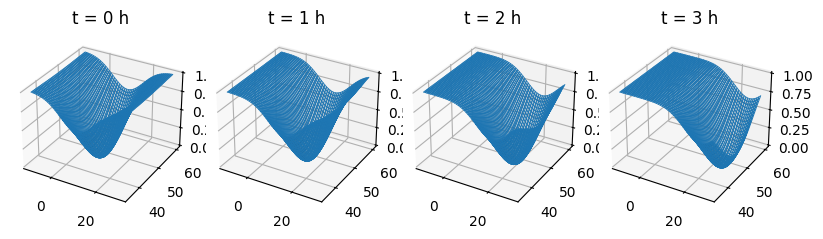

In [13]:

fig, axes = plt.subplots(1, 4, figsize=(8, 6), subplot_kw={"projection": "3d"})
axes = axes.flatten()

for i in range(len(ts)):
    ax = axes[i]
    ax.plot_surface(
        X[:, :, 0, i],
        Y[:, :, 0, i],
        V[:, :, 0, i],
        edgecolor="tab:blue",
        lw=0.5,
        alpha=0.3,
    )
    ax.set_title(f"t = {i} h")

plt.tight_layout()
plt.show()

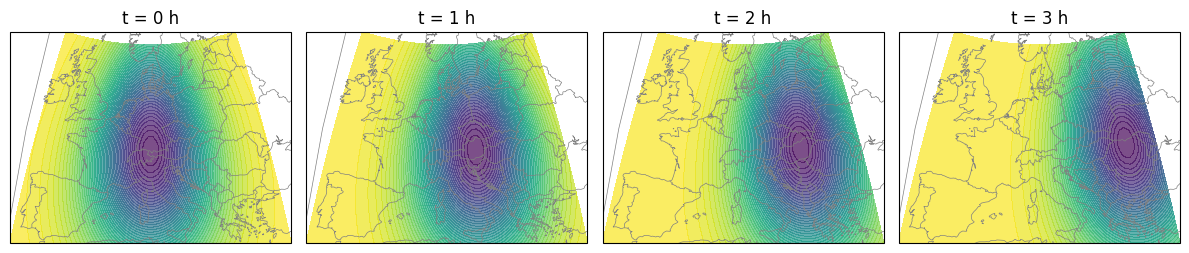

In [14]:
fig, axes = plt.subplots(
    1,
    4,
    figsize=(12, 4),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)


for t in range(len(ts)):
    ax = axes[t]
    ax.set_title(f"t = {t} h")
    ax.set_extent([-10, 30, 35, 60])
    ax.add_feature(cf.BORDERS, lw=0.5, color="gray")
    ax.coastlines(resolution="50m", lw=0.5, color="gray")

    ax.contourf(
        X[:, :, 0, t],
        Y[:, :, 0, t],
        V[:, :, 0, t],
        transform=ccrs.PlateCarree(),
        alpha=0.7,
        cmap="viridis",
        levels=50,
    )

plt.tight_layout()
plt.show()

## construct the cost data frame

Now we construct the cost data, which should have the same structure as follows


In [16]:
df_cost = pd.DataFrame(
    np.array([X, Y, Z, TS, V]).reshape(5, -1).T,
    columns=["longitude", "latitude", "h", "ts", "cost"],
).sort_values(["ts", "h", "latitude", "longitude"], ascending=True)

df_cost

,longitude,latitude,h,ts,cost
0,-10.000000,35.0,0.0,0.0,0.992742
40,-9.183673,35.0,0.0,0.0,0.990202
80,-8.367347,35.0,0.0,0.0,0.986874
120,-7.551020,35.0,0.0,0.0,0.982579
160,-6.734694,35.0,0.0,0.0,0.977120
...,...,...,...,...,...
99839,26.734694,60.0,13000.0,10800.0,0.642505
99879,27.551020,60.0,13000.0,10800.0,0.654778
99919,28.367347,60.0,13000.0,10800.0,0.671036
99959,29.183673,60.0,13000.0,10800.0,0.690670


## Set up the new objective function

General steps to set you own objective function / cost grid:

1. generate the interpolate model (linear) based on the grid data
2. define the objective function
3. pass the new objective function and interplant model to optimizer's `trajectory()` generator

(Note: this process can take a while, ~1 minute with a modern computer)


In [17]:
optimizer = top.Cruise("A320", "EHAM", "LGAV", m0=0.85)
optimizer.init_conditions(h_min=32_000 * aero.ft, h_max=36_000 * aero.ft)
optimizer.fix_cruise_altitude()
optimizer.setup_dc(nodes=40)
optimizer.debug = False

# the inpterpolant required for the cost grid
interpolant = top.tools.interp_grid(
    df_cost.longitude.unique(),
    df_cost.latitude.unique(),
    df_cost.h.unique(),
    df_cost.ts.unique(),
    df_cost.cost,
    shape="linear",
)


def obj_grid(x, u, dt, **kwargs):
    """The final cost is the compound of the 4d grid cost and fuel"""
    # grid cost unit is: cost/time
    grid_cost = optimizer.obj_grid_cost(x, u, dt, **kwargs) * dt
    fuel_cost = optimizer.obj_fuel(x, u, dt, **kwargs)
    return grid_cost * 2 + fuel_cost


# generate the flight trajectory
# interpolant is passed to trajectory() and then to obj_grid() internally
flight = optimizer.trajectory(
    objective=obj_grid,
    interpolant=interpolant,
    h_min=32_000 * aero.ft,
    h_max=36_000 * aero.ft,
)

## Visualize the trajectory


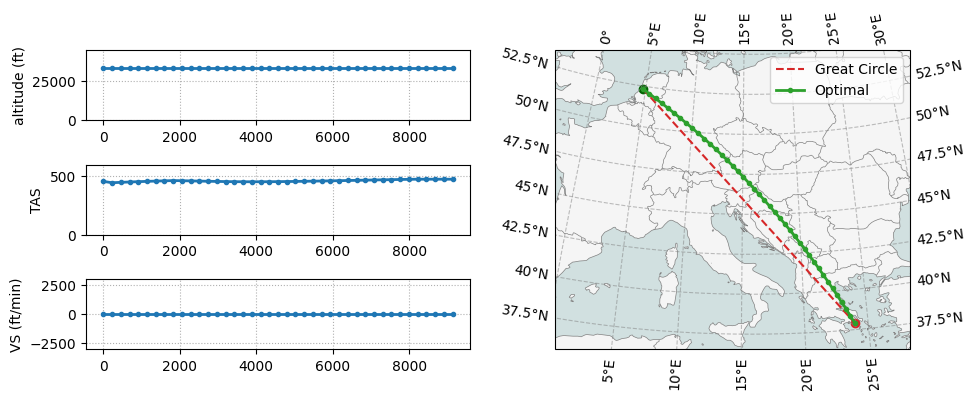

In [18]:
top.vis.trajectory(flight)
plt.show()

### Visualize the projected 4D cost along the trajectory


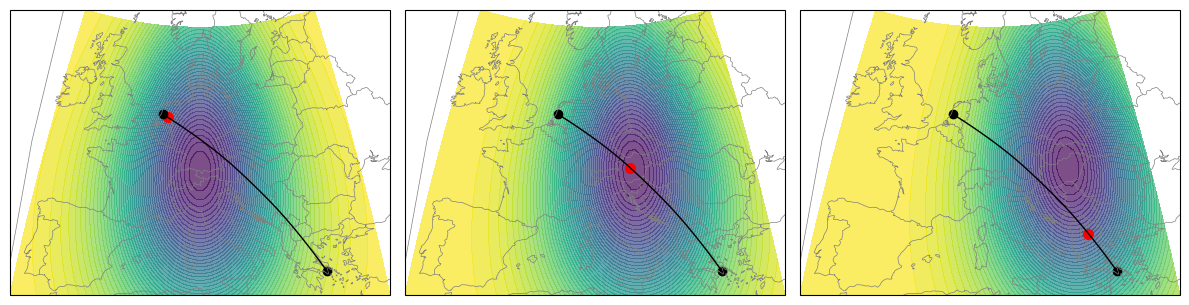

In [19]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(12, 6),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)

for t in range(3):
    ax = axes[t]
    ax.set_extent([-10, 30, 35, 60])
    ax.add_feature(cf.BORDERS, lw=0.5, color="gray")
    ax.coastlines(resolution="50m", lw=0.5, color="gray")

    df_cost_pivot = df_cost.query(f"h==0 and ts=={t*3600}").pivot(
        index="latitude", columns="longitude", values="cost"
    )

    lat, lon, val = (
        df_cost_pivot.index.values,
        df_cost_pivot.columns.values,
        df_cost_pivot.values,
    )

    ax.contourf(
        lon,
        lat,
        val,
        transform=ccrs.PlateCarree(),
        alpha=0.7,
        cmap="viridis",
        levels=50,
    )

    current_data = flight.query(f"{t*3600}<ts<{t*3600+600}").iloc[0]

    ax.scatter(
        current_data.longitude,
        current_data.latitude,
        color="r",
        lw=2,
        transform=ccrs.PlateCarree(),
    )

    ax.plot(
        flight.longitude, flight.latitude, color="k", lw=1, transform=ccrs.PlateCarree()
    )

    ax.scatter(
        flight.longitude.iloc[0],
        flight.latitude.iloc[0],
        c="k",
        transform=ccrs.PlateCarree(),
    )
    ax.scatter(
        flight.longitude.iloc[-1],
        flight.latitude.iloc[-1],
        c="k",
        transform=ccrs.PlateCarree(),
    )

plt.tight_layout()
plt.show()